<a href="https://colab.research.google.com/github/dingjun6953/Accelerate-Python-codes-using-proper-libraries/blob/main/PySpark_ML_Gradient_boosted_tree_Dingjun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 13.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=d7d40476237c185731ab98fb29b6686b62b9349c846fd9caf07bc4cb4b940877
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [43]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
import pandas as pd

In [39]:
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['label'] = pd.Series(iris.target)
 
print(df_iris.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


In [54]:
spark=SparkSession.builder.appName('Pyspark_Dingjun').getOrCreate()
sqlContext = SQLContext(spark)

data = sqlContext.createDataFrame(df_iris)
print(data.printSchema())
 

root
 |-- sepal length (cm): double (nullable = true)
 |-- sepal width (cm): double (nullable = true)
 |-- petal length (cm): double (nullable = true)
 |-- petal width (cm): double (nullable = true)
 |-- label: long (nullable = true)

None


/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [42]:
features = iris.feature_names

va = VectorAssembler(inputCols=features, outputCol='features')

va_df = va.transform(data)
va_df = va_df.select(['features', 'label'])
va_df.show(3)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[5.1,3.5,1.4,0.2]|    0|
|[4.9,3.0,1.4,0.2]|    0|
|[4.7,3.2,1.3,0.2]|    0|
+-----------------+-----+
only showing top 3 rows



In [46]:
(train, test) = va_df.randomSplit([0.8, 0.2])

In [47]:
gbtr = GBTRegressor(featuresCol='features', labelCol='label', maxIter=10)
gbtr = gbtr.fit(train)

pred = gbtr.transform(test)
pred.show(3) 

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.8,3.4,1.6,0.2]|    0|       0.0|
|[4.8,3.4,1.9,0.2]|    0|       0.0|
|[4.9,3.0,1.4,0.2]|    0|       0.0|
+-----------------+-----+----------+
only showing top 3 rows



In [49]:
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from sklearn.metrics import confusion_matrix
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8973295307233602
Confusion Matrix:
[[9 0 0]
 [0 9 3]
 [0 0 8]]


In [50]:
from pyspark.ml.evaluation import RegressionEvaluator
mdata = gbtr.transform(test)
mdata.show(3)
 
rmse=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse=rmse.evaluate(mdata) 
 
mae=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae=mae.evaluate(mdata) 
 
r2=RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2=r2.evaluate(mdata)

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R-squared: ", r2)

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.8,3.4,1.6,0.2]|    0|       0.0|
|[4.8,3.4,1.9,0.2]|    0|       0.0|
|[4.9,3.0,1.4,0.2]|    0|       0.0|
+-----------------+-----+----------+
only showing top 3 rows

RMSE:  0.3216337604513384
MAE:  0.10344827586206896
R-squared:  0.8231707317073171


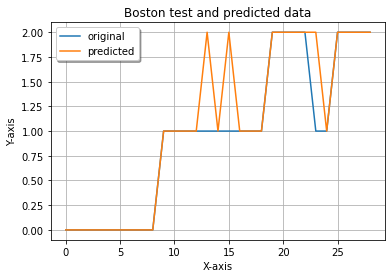

In [53]:
import matplotlib.pyplot as plt
x_ax = range(0, mdata.count())
y_pred=mdata.select("prediction").collect()
y_orig=mdata.select("label").collect()
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 